In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
import sys
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10, 8) # set default figure size, 8in by 6in

# Assignment 03: Logistic Regression

**Due Date:** Friday 10/5/2018 (by midnight)


## Introduction 

In this exercise, you will implement logistic regression on a new data set.  We will then practice
using the `NumPy` optimization methods in order to fit a set of parameters to this data set.  Thus
you will be writing the cost and gradient functions needed by the `NumPy` optimization routines
in order to search for the optimal theta parameters for the given data set.

## Logistic Regression

In this part of the exercise, you will build a logistic regression model to
predict whether a student gets admitted into a university.

Suppose that you are the administrator of a university department and
you want to determine each applicant’s chance of admission based on their
results on two exams. You have historical data from previous applicants
that you can use as a training set for logistic regression. For each training
example, you have the applicant’s scores on two exams and the admissions
decision. 

Your task is to build a classification model that estimates an applicant’s
probability of admission based the scores from those two exams.

**Visualizing the Data**

Before starting to implement any learning algorithm, it is always good to
visualize the data if possible. In the next cell we have loaded the data
set for you from the course repository into the standard x and y variables:


In [2]:
data = pd.read_csv('data/assg-03-data.csv', names=['exam1', 'exam2', 'admitted'])
x = data[['exam1', 'exam2']].values
y = data.admitted.values
m = y.size

print(x.shape)
print(y.shape)
print(m)

(100, 2)
(100,)
100


The file contains data from 100 students.  In `X` there are two input variables, the scores for Exam 1
and Exam 2 that each student got.  In the `y` vector are 100 outputs, which are positive and negative
results, which in this care are whether the student was admitted (a 1) or not (a 0) given their test
scores (and presumably other admission materials).

In the next cell, plot the Exam 1 and Exam 2 scores on the x and y axis of a scatter plot.  However,
use yellow circles for the negative examples markers (not admitted, or where y==0), and use red
triangles for the positive examples (admitted, or where y==1).  You will need to create an index
for each set of positive and negative results, and perform two separate plot commands.  See our lecture
notebooks for an example with a data set of doing this plot.  Your final figure should look exactly
like this (don't forget to add x and y axis labels and a legend to the figure):

<img src="files/figures/assg-03-plot-1.png">

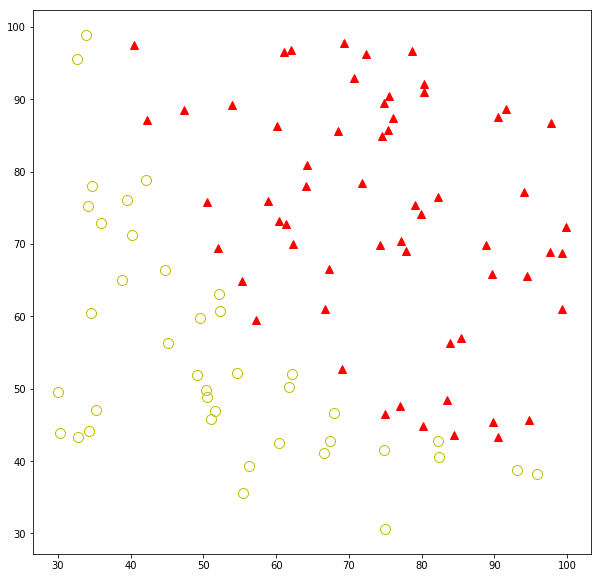

In [3]:
# plot the visualization of the exam scores here
pos_idx = np.where( y == 1 )
neg_idx = np.where(y == 0)

# plot the example figure
plt.figure(figsize=(10,10))

# plot the points in our two categories, y=0 and y=1, using markers to indicated
# the category or output
plt.plot(x[neg_idx,0], x[neg_idx,1], 'yo', markersize=10, fillstyle='none', markeredgewidth=1) 
plt.plot(x[pos_idx,0], x[pos_idx,1], 'r^', markersize=8, markeredgewidth=1) 



#plt.plot(x, y,'rx')
#plt.plot(x, y)

**Warmup Exercise: sigmoid function**

Before you start with the actual cost and gradient functions, recall that the logistic regression
hypothesis is defined as:

$$
h_\theta(x) = g(\theta^T x)
$$

where function $g()$ is the sigmoid function.  The sigmoid function is defined as:

$$
g(z) = \frac{1}{1 + e^{-z}}
$$

In the next cell, complete the function named `sigmoid` so it can be called by the rest of the cells
in this assignment.  Your `sigmoid` function should be a vectorized function.  That is, it should be
able to accept both scalar float values, as well as `NumPy` arrays of float values.  Recall that for 
negative values, the result of the sigmoid is close to 0, and for positive values, it is close to 1.
For an input of $z = 0$ the output of the sigmoid function is exactly $0.5$.

```python
print sigmoid(-5.0)
>>> 0.00669285092428
print sigmoid(0.0)
>>> 0.5
print sigmoid(5.0)
>>> 0.993307149076

z = np.linspace(-5.0, 5.0, 11)
print z
print sigmoid(z)
>>> [-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]
>>> [ 0.00669285  0.01798621  0.04742587  0.11920292  0.26894142  0.5
      0.73105858  0.88079708  0.95257413  0.98201379  0.99330715]
```

In [4]:
def sigmoid(z):
    """Calculate the sigmoid or logistic function on the values of z.  This is
    a vectorized function, so z can be a single simple scalar float value, or it
    can be a NumPy array of float values.  Any and all values given have their
    sigmoid computed and returned as a result of calling this function.
    """
    # your code goes here
    return 1 / (1+np.exp(-z))

In [5]:
print(sigmoid(-5.0))
print(sigmoid(0.0))
print(sigmoid(5.0))
z = np.linspace(-5.0, 5.0, 11)
print(z)
print(sigmoid(z))

0.0066928509242848554
0.5
0.9933071490757153
[-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]
[0.00669285 0.01798621 0.04742587 0.11920292 0.26894142 0.5
 0.73105858 0.88079708 0.95257413 0.98201379 0.99330715]


**Cost Function**

As we mentioned, we are going to be using the `NumPy` optimize library in order to find optimized $\theta$
parameters for a logistic regression of our admission data classification task.  We showed examples
of doing this in our Lecture notebooks this week.  In order to use something like BFGS optimization, we
need to supply a function that computes the cost for the data given some set of $\theta$ parameters, and
also a function that calculates the gradients, or the partial derivatives, of the $\theta$ parameters.

First of all lets implement a function to compute the cost using our logistic cost function.  Recall
that the logistic cost function is as follows:

$$
J(\theta) = -\frac{1}{m} \big[ \sum_{i=1}^m  y^{(i)} \; \textrm{log} (h_\theta(x^{(i)})) + (1 - y^{(i)}) \; \textrm{log} (1 - h_\theta(x^{(i)})) \big]
$$

Also recall that our hypothesis function for logistic regression is:

$$
h_{\theta}(x) = g(\theta^T x)
$$

Where $g(z)$ is the sigmoid or logistic function, which you should have just implemented in the previous
cell.

Notice that the cost function $J()$ is a function of the $\theta$ parameters, as well as of the inputs
$x$ and the correct outputs $y$ (which are all either 0 or 1 for this logistic classification task).
In the next cell, implement the cost function for logistic regression.  I have given you the
signature of the function, your task is to implement the logic to calculate the cost.

In [6]:
def compute_logistic_cost(theta, X, y):
    """Compute the cost function for logistic regression.  
    
    Given a set of inputs X (we assume that the first column has been 
    initialized to 1's for the theta_0 parameter), and the correct 
    outputs for these inputs y, calculate the logistic regression cost
    for the given input/outputs as defined by the theta parameters.
    
    Args
    ----
    theta (numpy nx1 array) - An array of the set of theta parameters
       to evaluate
    X (numpy mxn array) - The example inputs, first column is expected
       to be all 1's.
    y (numpy m size array) - A vector of the correct outputs of length m
       
    Returns
    -------
    J (float) - The sum squared difference cost function for the given
       theta parameters
    """
    
    # determine the number of training examples from the size of the correct outputs
    m = len(y)
    
    # You need to return the following variable correctly
    J = 0.0
    
    # ===== Your Code Here ======
    # Instructions: Compute the cost of a particular choice of theta
    # and return the resulting cost J
    # Don't forget to use the sigmoid function you just created above when computing the
    # hypothesis
    
    # we are taking the log of the hypothesis and the log of (1.0 - hypothesis).  However, the
    # logarithm is undefined for the value 0, and it is possible that you can end up with
    # a value close to 0 or 1 from the sigmoid function.  To avoid problems, I usually threshold
    # the hypothesis values before taking the log of them.  For example, if I used matrix
    # operations to calculate all of the hypothesis for all the inputs, and ended up with
    # a NumPy array called hypothesis, I could use the following code to set all values
    # that are close to 0, to some small epsilon instead, and likewise to find and set all
    # values that are close to 1, and set them to be not quite so close to 1.
    #eps = 1e-12
    #hypothesis[hypothesis < eps] = eps
    #eps = 1.0 - 1e-12
    #hypothesis[hypothesis > eps] = eps

    # feel free to implement the cost function as a loop or using matrix operations, you
    # can do it either way.  
    hypothesis = sigmoid(np.dot(theta.T, X)).T
    eps = 1e-12
    hypothesis[hypothesis < eps] = eps
    eps = 1.0 - 1e-12
    hypothesis[hypothesis > eps] = eps
    J = -(1/m) * (np.dot(y, np.log(hypothesis)) + np.dot((1-y), np.log(1 - hypothesis)))
    
    # return the calculated cost in the J variable
    return J

If you use the same epsilon value that I used above to threshold any hypothesis values that are close
to 0 or 1, you should get close to the following results when using your cost function:

```python
theta = np.zeros( (3, 1) )
print compute_logistic_cost(theta, X, y)
>>> 0.69314718056

theta = np.array([[1.0],
                  [1.0],
                  [1.0]])
print compute_logistic_cost(theta, X, y)
>>> 11.0524172952

theta = np.array([[0.1],
                  [0.1],
                  [0.1]])
print compute_logistic_cost(theta, X, y)
>>> 4.30613550295
```

In [7]:
# Recall that for a model with inputs, we actually use 3 parameters, theta_0, theta_1 
# and theta_2.  The inputs X need to have an initial column of all 1's for the theta_0
# parameter.  So for our current data, X needs to be a 3xm shaped set of data, where 
# the first value in each column is 1.0, and the next value in each column is our raw inputs
X = np.ones( (3, m) )
X[1:,:] = x.T # the second column contains the raw inputs

In [8]:
theta = np.zeros( (3, 1) )
print(compute_logistic_cost(theta, X, y))

theta = np.array([[1.0],
                  [1.0],
                  [1.0]])
print(compute_logistic_cost(theta, X, y))

theta = np.array([[0.1],
                  [0.1],
                  [0.1]])
print(compute_logistic_cost(theta, X, y))

[0.69314718]
[11.0524173]
[4.3061355]


**Gradient Function**

As we showed in the lecture videos and notebooks, for the `NumPy` optimization functions we can also
provide a function that determines the gradient (the partial derivative) with respect to each of
the $\theta$ parameters of our model. We presented the following equation for the gradient of the cost.
Recall that the gradient of the cost is a vector of the same length as $\theta$ where the $j^{th}$
element (for $j = 0, 1, \ldots, n)$ is defined as follows:

$$
\frac{\partial J(\theta)}{\partial \theta_j} =  \frac{1}{m} \sum_{i=1}^m (h_\theta(x^{(i)}) - y^{(i)}) x_j^{(i)}
$$

Note that while this gradient looks identical to the linear regression gradient, the formula is actually
different because linear and logistic regression have different definitions of $h_\theta(x)$.  So don't
forget that you have to use the sigmoid function to calculate your hypothesis in the next cell.

In the following cell, you will implement a function called `compute_logistic_cost_gradients` that
will implement the calculation to find the gradients for each of the $\theta$ parameters.  As
we demonstrated in the lecture 05 notebook, this function needs to return a n+1 dimensional vector
of the gradients for each of the $\theta$ parameters.

In [9]:
def compute_logistic_cost_gradients(theta, X, y):
    """Compute the gradients of the theta parameters for our logistic regression
    cost function.
    
    Given a set of inputs X (we assume that the first column has been 
    initialized to 1's for the theta_0 parameter), and the correct 
    outputs for these inputs y, calculate the gradient of the cost function
    with respect to each of the theta parameters.
    
    Args
    ----
    theta (numpy nx1 array) - An array of the set of theta parameters
       to evaluate
    X (numpy mxn array) - The example inputs, first column is expected
       to be all 1's.
    y (numpy m size array) - A vector of the correct outputs of length m
       
    Returns
    -------
    gradients - A numpy n sized vector of the computed gradients.
    """

    # determine the number of training examples from the size of the correct outputs
    # and the number of parameters from the size of theta
    m = len(y)
    n = len(theta)
    
    # You need to return the following variable with the correctly calculated
    # gradients of theta
    gradients = np.zeros(n)
    
    # your code goes here
    hypothesis = sigmoid(np.dot(theta.T, X))
    gradients = (np.dot(hypothesis-y, np.transpose(X)).T)*(1/m)
    
    # return the numpy n sized vector of gradients
    return gradients

Here are some example gradient values you should get if you implement the above function correctly:

```python
theta = np.zeros( (3, 1) )
print compute_logistic_cost_gradients(theta, X, y)
>>> [ -0.1        -12.00921659 -11.26284221]

theta = np.array([[1.0],
                  [1.0],
                  [1.0]])
print compute_logistic_cost_gradients(theta, X, y)
>>> [  0.4         20.81292044  21.84815684]

theta = np.array([[0.1],
                  [0.1],
                  [0.1]])
print compute_logistic_cost_gradients(theta, X, y)
>>> [  0.39997223  20.81184964  21.84684953]
```

In [10]:
theta = np.zeros( (3, 1) )
print(compute_logistic_cost_gradients(theta, X, y))

theta = np.array([[1.0],
                  [1.0],
                  [1.0]])
print(compute_logistic_cost_gradients(theta, X, y))

theta = np.array([[0.1],
                  [0.1],
                  [0.1]])
print(compute_logistic_cost_gradients(theta, X, y))

[[ -0.1       ]
 [-12.00921659]
 [-11.26284221]]
[[ 0.4       ]
 [20.81292044]
 [21.84815684]]
[[ 0.39997223]
 [20.81184964]
 [21.84684953]]


**Learning Parameters using SciPy Optimize**

In the previous assignment, you found the optimal parameters of a linear regression model by implementing
the gradient descent algorithm youself by hand.  You wrote a cost function and calculated its gradient,
then took a gradient descent step accordingly.

This time, we will be using the `SciPy` optimization library routines, as we did in our lecture
notebook, to use your cost and gradient functions to search for the optimal theta parameters for you.
`SciPy`'s `minimize` function in the optimization library will find the theta parameters that minimize
the cost function for the given data set.  This should correspond to the best decision boundary
we can make for our given data, to differentiate between admit and no admit categories.

`SciPy`'s `minimize` function is an optimization solver that finds the minimum of an unconstrained
function.  For logistic regression, you want to optimize the cost function $J(\theta)$ with
parameters $\theta$.

Concretely, you are going to use `minimize` to find the best parameters $\theta$ for the logistic
regression cost function, given a fixed dataset (of X and y values).  You will pass to `minimize` the
following inputs:

- The initial values of the parameters we are trying to optimize
- A function that, when given the training set and a particular set of $\theta$ values, computes
  the logistic regression cost of the dataset.
- A function that, when given the training set and a particular set of $\theta$ values, computes
  the gradient of the cost with respect to $\theta$ for the dataset.
  
In the following cell, use the example from the Lecture 5 notebook to correctly call the
`minimize` function from `SciPy` using the cost and gradient functions you developed above.
You should use an initial set of theta parameters of all 0's to start with.  Any of the
optimization methods we demonstrated should work to find the optimal parameters (BFGS, CG,
L-BFGS-B), though for me it looks like the CG solver is not converging correctly, so you probably
need to use one of the BFGS methods.

For me, the optimum cost is about 0.203498, and this optimum happens with the following theta values:

```python
Optimization terminated successfully.
         Current function value: 0.203498
         Iterations: 20
         Function evaluations: 31
         Gradient evaluations: 31
[-25.16133596   0.20623176   0.2014716 ]
```

In [11]:
from scipy.optimize import minimize
theta = np.zeros( 3 ) # initial theta parameters to start gradient descent from
res = minimize(compute_logistic_cost, theta, method='BFGS', jac=compute_logistic_cost_gradients, args=(X, y),
               options={'disp': True})
print(res.x) # res is n object, the x variable in res has the optimized parameters

Optimization terminated successfully.
         Current function value: 0.203498
         Iterations: 20
         Function evaluations: 27
         Gradient evaluations: 27
[-25.16133586   0.20623176   0.2014716 ]


** Evaluating Logistic Regression **

If you got the `minimize` optimization function to work correctly, you should have 3 values for your
$\theta$ parameters in the `res.x` member variable of your result.  Lets replot your first figure, but
use these $\theta$ parameters to visualize the decision boundary that was found with our logistic
regression.

Recall that the theta parameters represent a set of values that give us a decision boundary.  If
we have the hypothesis:

$h_\theta(x) = g(\theta_0 + \theta_1 x_1 + \theta_2 x_2)$

for some given values of theta, we will predict that $y = 1$ when:

$\theta_0 + \theta_1 x_1 + \theta_2 x_2 \ge 0$

Recall that the $\theta$ parameters are simply scalar values, and we know the values we want to use
for these 3 parameters from our previous cell.  Also recall that the decision boundary that divides
our prediction between $y = 1$ and $y = 0$ occurs when the above equation is exactly 0:

$\theta_1 x_1 + \theta_2 x_2 = - \theta_0$

We can solve this equation for $x_2$, for example:

$x_2 = - \frac{\theta_0 + \theta_1 x_1}{\theta_2}$

Given this and particular values for $\theta$, we can then draw the decision boundary line
on a figure by selecting some $x_1$ points and calculating the $x_2$ values.

In the next cell, recreate our first figure showing all 100 student's data points, with markers 
coding for the admit/no admit categories.  Then add a blue line to represent the optimal decision
boundary that was found from our previous cell optimization.  If you have done optimization and
visualization correctly, your figure should look like this:

<img src="files/figures/assg-03-plot-2.png">

[30.60326323 99.8278578 ]


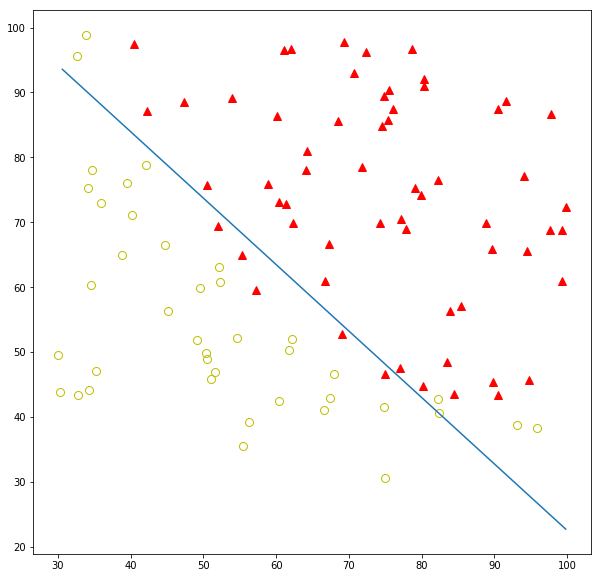

In [12]:
# plot the visualization of the exam scores here
pos_idx = np.where( y == 1 )
neg_idx = np.where(y == 0)

# plot the example figure
plt.figure(figsize=(10,10))

# plot the points in our two categories, y=0 and y=1, using markers to indicated
# the category or output
plt.plot(x[pos_idx,0], x[pos_idx,1], 'r^', markersize=8, markeredgewidth=1)
plt.plot(x[neg_idx,0], x[neg_idx,1], 'yo', markersize=8, fillstyle='none', markeredgewidth=1) 
 

 

# We got these theta vals
# theta_0 = -25.16133586 , theta_1 = 0.20623176, theta_2 = 0.2014716

#x = np.array([X[:,0].max(),X[:,1].max()])

x = np.array([X[2:].min(),X.max()])
y = -((res.x[0] + res.x[1]*x))/ res.x[2]
plt.plot(x, y)
print(x)

After learning the parameters, you can use the model to predict whether a particular student
will be admitted or not.  For a student with an Exam 1 score of 45 and an Exam 2 score of 85, you 
should expect to see an admission probability of 0.776.

Write a function in the next cell, called `model_predictions`.  This function should take
an array of `theta` parameters, and a matrix like our X matrix, that represents exam scores (plus an
additional first column of 1's).  This function will return a vector of the computed probabilities.

For example, if I give the function the following set of new student scores, it will return the following
predicted probability for the students:

```python
X_new = np.array([[ 1,  1,  1,  1],
                  [45, 55, 75, 95],
                  [85, 75, 35, 85]])
theta = np.array([[-25.16133596],
                  [0.20623176],
                  [0.2014716]])

print model_predictions(theta, X_new)
>>> [[ 0.77629063  0.78444846  0.066456    0.99999042]]
```

In [13]:
def model_predictions(theta, X):
    """Given a set of theta parameters, and a set of inputs in X, calculate the models
    prediction of admission.
    
    theta (numpy nx1 array) - An array of the set of theta parameters
       to evaluate
    X (numpy nxm array) - The example inputs, first column is expected
       to be all 1's.
    """
    # put your code here
    #PRediction is nothing but Hypothesis function, not using log here because it's not for cost
    hypothesis = sigmoid(np.dot(theta.T, X))
    return hypothesis

In [14]:
X_new = np.array([[ 1,  1,  1,  1],
                  [45, 55, 75, 95],
                  [85, 75, 35, 85]])
theta = np.array([[-25.16133596],
                  [0.20623176],
                  [0.2014716]])
#print("Model pred is")
print(model_predictions(theta, X_new))

[[0.77629063 0.78444846 0.066456   0.99999042]]


Another way to evaluate the quality of the parameters we have found is to see how well the learned
model predicts on our training set.  You can easily use the results from your `model_predictions`
function to get predicted probabilities for all of our original `X` data in the training set.  If
we threshold these results at the 0.5 level, you should end up with an array of 100 1s and 0's (or true
and false).
Using this array, and the array `y` containing the correct answers, compute the percentage of
inputs that our model gets correct from our training data set.  From the previous figure, you 
should be able to see that the model decision boundary gets about 11 of the inputs in the wrong category,
given an 89% accuracy.  In the next cell, compute the accuracy of our logistic model.